In [1]:
# CONFIGURATION 

import os
os.environ["OPENAI_API_KEY"] = ""
os.environ["TAVILY_API_KEY"] = ""

os.environ["SYMBL_AI_APP_ID"]     = "''"
os.environ["SYMBL_AI_APP_SECRET"] = "''"


In [5]:
# -----------------------
# Tools
# -----------------------

import yfinance as yf

# Check ticker price
def get_stock_price(ticker: str) -> float:
    stock = yf.Ticker(ticker)
    val = stock.history(period='1d',interval='1m')['Close'].iloc[-1]
    print("calling yf for stock price ",ticker,"val:",val)
    return "Stock price is "+str(val)
    
#get_stock_price("NVDA") 


import base64
import requests
def analyze_image(image_path):
    api_key = os.environ.get("OPENAI_API_KEY")
    
    headers = {
      "Content-Type": "application/json",
      "Authorization": f"Bearer {api_key}"
    }

    with open(image_path, "rb") as image_file:
        base64_image = base64.b64encode(image_file.read()).decode('utf-8')
        
    payload = {
      "model": "gpt-4o-mini",
      "max_tokens": 300,
      "messages": [
        {
          "role": "user",
          "content": [
            {
              "type": "text",
              "text": "What’s in this image?"
            },
            {
              "type": "image_url",
              "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"}
            }
          ]
        }
      ],
    }
    
    response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)
    # {'id': 'chatcmpl-9RRYu5W77ZoNKUUsdp84XFk2Pbxvg', 'object': 'chat.completion', 'created': 1716327832, 'model': 'gpt-4o', 
    #  'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'The image displays multiple DVD or poster covers for ...'}, 
    #               'logprobs': None, 'finish_reason': 'stop'}], 
    #  'usage': {'prompt_tokens': 1118, 'completion_tokens': 142, 'total_tokens': 1260}, 'system_fingerprint': 'fp_927397958d'}
    print(response.json())
    result = response.json()['choices'][0]['message']['content']
    return result

#analyze_image(image_path="../input_images/image.demo.0.png")


from tavily import TavilyClient
def search_engine( query ):
    result = ""
    print("Search Engine Query:", query)

    tavily = TavilyClient(api_key=os.environ["TAVILY_API_KEY"])
    response = tavily.search(query=query, max_results=2)
    for content in response["results"]:
        result += content["content"]
    return result

#search_engine("What is James Bond's nationality ?")


In [6]:
# -----------------------
# Tool Calling Support
# -----------------------

import inspect
class Function:
    def __init__(self, func):
        self.func = func
        self.name = func.__name__
        self.arg_def = {}
        for name, param in inspect.signature(self.func).parameters.items():
            # {'ticker': {'type': <class 'str'>, 'value': None, 'default': <class 'inspect._empty'>}}
            self.arg_def[ name ]={"type":param.annotation, "value":None, "default":param.default}            
        # i.e. <class 'float'>
        self.return_type = inspect.signature(self.func).return_annotation
        
class ToolCall:
    def __init__(self, func):
        self.function = Function(func)
        self.arguments = {}

    def __call__(self, parameter):
        for key, arg_def in self.function.arg_def.items():
            self.function.arg_def[ key ]["value"]=parameter
            self.arguments[ key ]=parameter
        result = self.function.func(parameter)
        print("calling:", self.function.name, "args:", self.function.arg_def, "result:", result)
        return result

#tool = ToolCall(get_stock_price)
#print(tool("TSLA"))

#tool = ToolCall(analyze_image)
#print(tool("../input_images/image.demo.0.png"))

#tool = ToolCall(search_engine)
#print(tool("What nationality is James Bond ?"))


from openai import OpenAI
from langchain.output_parsers import ResponseSchema
from langchain.output_parsers import StructuredOutputParser

def check_tools_invocation(dialog, tools):    
    client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))

    _dialog = dialog
    _tools = "Tools:\n"
    for tool in tools:
        _tools += "- "+tool["description"]+"\n"

    _prompt = """
    ### Instruction: If there is an explicit request for information in the input dialog, see if an input tool can answer it, then identify the tool and parameter needed, otherwise return '' for tool and parameter.

    ### Input:
    Input Dialog:
    %s
    
    Input Tools: 
    %s

    Format Instructions:
    %s
    
    ### Response:
    """

    tool_name_schema = ResponseSchema(name="tool", description="output the name of the tool")
    parameter_schema = ResponseSchema(name="parameter", description="output the value of parameter to be passed into the tool")

    response_schemas = [tool_name_schema, parameter_schema]
    output_parser = StructuredOutputParser.from_response_schemas(response_schemas)
    
    _format_instructions = output_parser.get_format_instructions()
    _prompt = _prompt % (_dialog, _tools, _format_instructions)
    
    messages=[{"role": "system", "content": ""}, {"role": "user", "content": _prompt}]
    completion = client.chat.completions.create(model="gpt-4o-mini", messages=messages) 
    result_dict = output_parser.parse(completion.choices[0].message.content)
    # i.e. result_dict={'tool': 'get_stock_price', 'parameter': 'NVIDIA'}
    print("Tool Matching Result:", result_dict)

    result = None
    for tool in tools:
        # i.e. {"tool": ToolCall(), "description":tool_description}
        if result_dict["tool"]==tool["tool"].function.name:    # ToolCall.function
            result = tool["tool"]( result_dict["parameter"] )  # ToolCall.__call__
        
    return result


_dialog = """
i'm fine, how are you doing
"""
# UNIT TESTS:
# how are you doing
# can you check Tesla Stock
# can you describe this image '../input_images/image.demo.0.png'
# do you know what happened recently with Charlotte Flair ?


# Test tool invocation support
tools = []
tools.append( {"tool": ToolCall(get_stock_price), "description":"name: get_stock_price, parameter: ticker symbol, returns: price of stock"} )
tools.append( {"tool": ToolCall(analyze_image), "description":"name: analyze_image, parameter: image that needs to be described, returns: description of image"} )
tools.append( {"tool": ToolCall(search_engine), "description":"name: search_engine, parameter: request, returns: answer to request"} )

check_tools_invocation(_dialog, tools)


Tool Matching Result: {'tool': '', 'parameter': ''}


In [7]:
import re
import time
from openai import OpenAI

system_prompt="""You are a personal companion having a dialog with a User. \
System prompts will be provided to help drive the conversation including \
description of images or answers to questions. 
Try to elicit some topic the user is interested in to discuss.
"""

def call_open_ai(messages):
    client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))
    # https://platform.openai.com/docs/models/overview
    # https://platform.openai.com/account/billing/preferences
    # https://platform.openai.com/account/usage
    
    completion = client.chat.completions.create(model="gpt-4o-mini", messages=messages)
    return completion.choices[0].message.content

class Conversation:
    def __init__(self, system_prompt=""):
        self.messages = []
        self.tools = []
        
        if system_prompt:
            self.messages.append({"role": "system", "content": system_prompt})

        self.tools.append( {"tool": ToolCall(get_stock_price), "description":"name: get_stock_price, parameter: ticker symbol, returns: price of stock"} )
        self.tools.append( {"tool": ToolCall(analyze_image),   "description":"name: analyze_image, parameter: image that needs to be described, returns: description of image"} )
        self.tools.append( {"tool": ToolCall(search_engine),   "description":"name: search_engine, parameter: request, returns: answer to request"} )

    
    def system(self, system_prompt):
        self.messages.append({"role": "system", "content": system_prompt})

    def assistant(self, assistant_prompt):
        self.messages.append({"role":"assistant", "content":assistant_prompt})

    def user(self, user_prompt):
        self.messages.append({"role":"user", "content":user_prompt})

    def chat(self):
        if self.tools and self.messages:
            _dialog = []
            #for message in self.messages:
            #    _dialog.append(message['content'])
            _dialog.append(self.messages[-1]['content'])
            _dialog = "\n".join(_dialog)
            invoke_response = check_tools_invocation(_dialog, self.tools)
            if invoke_response:
                self.system( invoke_response + " Please explain to user in 1 to 2 sentences." )
                #self.messages.append({"role": "system", "content": invoke_response + " Please explain to user in 1 to 2 sentences."})
            
        response = call_open_ai(messages=self.messages)
        self.messages.append({"role":"assistant", "content":response})
        return response
        
    def generate(self, user_prompt):
        self.messages.append({"role": "user", "content":user_prompt})
        response = call_open_ai(messages=self.messages)
        self.messages.append({"role":"assistant", "content":response})
        
        return response


In [8]:
#!rm -rf ./researchdb

In [9]:
#
# Create Splits from Marker outputs using custom MarkdownImageTextSplitter
#    Marker project: https://github.com/VikParuchuri/marker/tree/master
#    Marker results copied into ./static directory
#
import os, re
from langchain_core.documents import Document
from langchain_community.document_loaders import TextLoader

class MarkdownImageTextSplitter:
    
    def __init__(self, chunk_size: int = 500, margin: int = 1):
        self.chunk_size = chunk_size # un-used
        self.margin = margin  # Number of paragraphs before and after the image reference to include

    def _split_into_paragraphs(self, text: str):
        """Split text into paragraphs."""
        # Split text by newlines, assuming paragraphs are separated by two newlines.
        return text.split("\n\n")

    def _contains_image(self, text: str) -> bool:
        """Check if a paragraph contains an image reference."""
        image_pattern = r'!\[.*?\]\(.*?\)'  # Regex to match image syntax ![alt](url)
        return bool(re.search(image_pattern, text))
        
    def split_text(self, text: str, metadata: dict):
        """Split markdown file, grouping paragraphs around image references."""
        paragraphs = self._split_into_paragraphs(text)
        chunks = []
        current_chunk = []
        
        # Traverse through the paragraphs and create chunks
        i = 0
        while i < len(paragraphs):
            paragraph = paragraphs[i]
            # Check if the paragraph contains an image reference
            if self._contains_image(paragraph):
                # Start a new chunk with some surrounding paragraphs
                chunk_start = max(0, i - self.margin)
                chunk_end = min(len(paragraphs), i + self.margin + 1)
                chunk = "\n\n".join(paragraphs[chunk_start:chunk_end])
                metadata["chunk_start"]=chunk_start; metadata["chunk_end"]=chunk_end
                chunks.append(Document(page_content=chunk, metadata=metadata))
                i = chunk_end  # Skip ahead to the next paragraph after the image + margin
            else:
                i += 1
        
        return chunks

# List to store loaded documents
documents = []
source_markdowns_dir = "./static"  # copied output from marker project

# Walk through all subdirectories and files and create Document objects
for dirpath, dirnames, filenames in os.walk(source_markdowns_dir):
    for filename in filenames:
        # Check if the file is a .md file and matches the directory name
        dir_name = os.path.basename(dirpath)
        if filename == f"{dir_name}.md":
            # Full path of the markdown file
            file_path = os.path.join(dirpath, filename)
            
            # Load the document using TextLoader            
            loader = TextLoader(file_path)
            for d in loader.load(): 
                documents.append(d)

# Split the documents based on MarkdownImageTextSplitter scheme above
text_splitter = MarkdownImageTextSplitter(margin=2)

split_documents = []
for document in documents:
    split_docs = text_splitter.split_text(document.page_content, document.metadata)  
    split_documents.extend(split_docs)

from langchain.embeddings.openai import OpenAIEmbeddings
embedding = OpenAIEmbeddings()

from langchain.vectorstores import Chroma
persist_directory = './researchdb/'

vectordb = Chroma.from_documents(
    documents=split_documents,
    embedding=embedding,
    persist_directory=persist_directory
)

print("ResearchDB Vector Database Created:")

/tmp/ipykernel_97765/4254519218.py:77: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 0.3.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAIEmbeddings`.
  embedding = OpenAIEmbeddings()


ResearchDB Vector Database Created:


In [10]:
from langchain.vectorstores import Chroma
from langchain.embeddings.openai import OpenAIEmbeddings
persist_directory = './researchdb/'

vectordb = Chroma(embedding_function=OpenAIEmbeddings(), persist_directory=persist_directory)

print("ResearchDB Vector Database Loaded:")

ResearchDB Vector Database Loaded:




---> Split Source: ./static/DiffusionModelsWithTransformers , MetaData:
 {'chunk_end': 165, 'chunk_start': 160, 'source': './static/DiffusionModelsWithTransformers/DiffusionModelsWithTransformers.md'} , Page Content:
 ## 2. Related Work

Transformers. Transformers [60] have replaced domainspecific architectures across language, vision [10], reinforcement learning [5, 25] and meta-learning [39]. They have shown remarkable scaling properties under increasing model size, training compute and data in the language domain [26], as generic autoregressive models [17] and as ViTs [63]. Beyond language, transformers have been trained to autoregressively predict pixels [6, 7, 38]. They have also been trained on discrete codebooks [59] as both autoregressive models [11,47] and masked generative models [4, 14]; the former has shown excellent scaling behavior up to 20B parameters [62]. Finally, transformers have been explored in DDPMs to synthesize non-spatial data; e.g., to generate CLIP image em

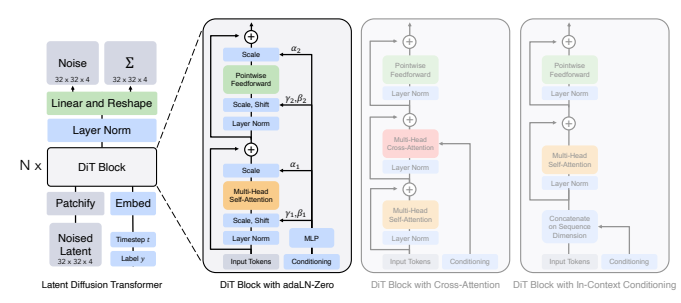



---> Split Source: ./static/DiffusionModelsWithTransformers , MetaData:
 {'chunk_end': 165, 'chunk_start': 160, 'source': './static/DiffusionModelsWithTransformers/DiffusionModelsWithTransformers.md'} , Page Content:
 ## 3.2. Diffusion Transformer Design Space

We introduce Diffusion Transformers (DiTs), a new architecture for diffusion models. We aim to be as faithful to the standard transformer architecture as possible to retain its scaling properties. Since our focus is training DDPMs of images (specifically, spatial representations of images), DiT
is based on the Vision Transformer (ViT) architecture which operates on sequences of patches [10]. DiT retains many of the best practices of ViTs. Figure 3 shows an overview of the complete DiT architecture. In this section, we describe the forward pass of DiT, as well as the components of the design space of the DiT class.

![3_image_0.png](3_image_0.png)

Figure 4. **Input specifications for DiT.** Given patch size p × p, a spatial re

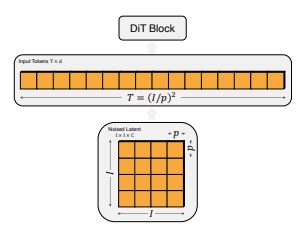



---> Split Source: ./static/DiffusionLMControllableTextGeneration , MetaData:
 {'chunk_end': 262, 'chunk_start': 257, 'source': './static/DiffusionLMControllableTextGeneration/DiffusionLMControllableTextGeneration.md'} , Page Content:
 A diffusion model [12, 27] is a latent variable model that models the data x0 ∈ R
das a Markov chain xT *. . .* x0 with each variable in R
d, and xT is a Gaussian. The diffusion model incrementally denoises the sequence of latent variables xT:1 to approximate samples from the target data distribution (Figure 2). The initial state pθ(xT ) ≈ N (0, I), and each denoising transition xt → xt−1 is parametrized by the model pθ(xt−1 | xt) = N (xt−1; µθ(xt, t), Σθ(xt, t)). For example, µθ and Σθ may be computed by a U-Net or a Tranformer.

To train the diffusion model, we define a forward process that constructs the intermediate latent variables x1:T . The forward process incrementally adds Gaussian noise to data x0 until, at diffusion step T, samples xT are ap

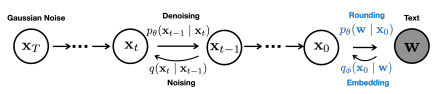



---> Split Source: ./static/TransformersLearnInContextByGradientDescent , MetaData:
 {'chunk_end': 276, 'chunk_start': 272, 'source': './static/TransformersLearnInContextByGradientDescent/TransformersLearnInContextByGradientDescent.md'} , Page Content:
 The construction and its discussion can be found in Appendix A.5. To provide evidence that copying is performed in trained Transformers, we optimize a two-layer self-attention circuit on in-context data where alternating tokens include input or output data i.e. e2j = (xj ) and e2j+1 = (0, yj ). We again measure the loss as well as the mean of the norm of the partial derivative of the first layer's output w.r.t. the input tokens during training, see Figure 5.

First, the training speeds are highly variant given different training seeds, also reported in Garg et al. (2022). Nevertheless, the Transformer is able to match the performance of a *single* (not two) step gradient descent. Interestingly, before the Transformer performance jumps

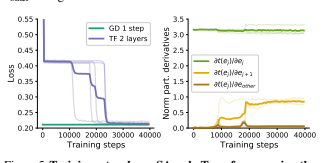



---> Split Source: ./static/StableVideoDiffusion , MetaData:
 {'chunk_end': 270, 'chunk_start': 265, 'source': './static/StableVideoDiffusion/StableVideoDiffusion.md'} , Page Content:
 # Stable Video Diffusion: Scaling Latent Video Diffusion Models To Large Datasets

Andreas Blattmann* Tim Dockhorn* Sumith Kulal* Daniel Mendelevitch

![0_image_0.png](0_image_0.png)

![0_image_1.png](0_image_1.png)

Maciej Kilian Dominik Lorenz Yam Levi Zion English Vikram Voleti Adam Letts Varun Jampani Robin Rombach Stability AI
Image file: ./static/StableVideoDiffusion/0_image_0.png


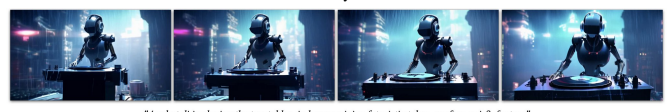

Image file: ./static/StableVideoDiffusion/0_image_1.png


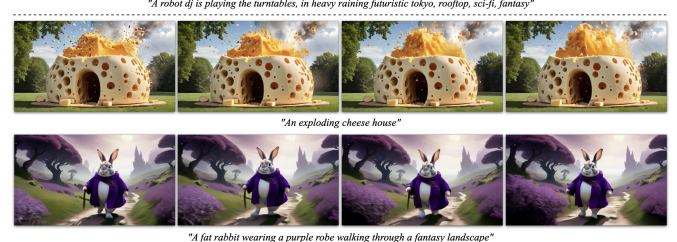



---> Split Source: ./static/DatabaseManagementSystems , MetaData:
 {'chunk_end': 1643, 'chunk_start': 1638, 'source': './static/DatabaseManagementSystems/DatabaseManagementSystems.md'} , Page Content:
 In this chapter, we discussed some of the distributed systems terminology and introduced some basic concepts. We've talked about the inherent difficulties and complications caused by the unreliability of the system components: links may fail to deliver messages, processes may crash, or the network may get partitioned. This terminology should be enough for us to continue the discussion. The rest of the book talks about the *solutions* commonly used in distributed systems: we think back to what can go wrong and see what options we have available.

## Further Reading

![252_Image_0.Png](252_Image_0.Png)

![252_Image_1.Png](252_Image_1.Png)

![252_Image_3.Png](252_Image_3.Png)
Image file: ./static/DatabaseManagementSystems/252_image_0.png


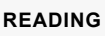

Image file: ./static/DatabaseManagementSystems/252_image_1.png


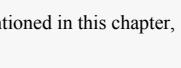

Image file: ./static/DatabaseManagementSystems/252_image_3.png




---> Split Source: ./static/DiffusionLMControllableTextGeneration , MetaData:
 {'chunk_end': 262, 'chunk_start': 257, 'source': './static/DiffusionLMControllableTextGeneration/DiffusionLMControllableTextGeneration.md'} , Page Content:
 On the one hand, having strong controllability in language models will help with mitigating toxicity, making the language models more reliable to deploy. Additionally, we can also control the model to be more truthful, reducing the inaccurate information generated by the language model by carefully controlling it to be truthful. On the other hand, however, one could also imagine more powerful targeted disinformation (e.g., narrative wedging) derived from the fine-grained controllability.

Towards this end, it might be worth considering generation methods that can watermark the generated outputs without affecting its fluency, and this type of watermark could also be framed as a controllable generation problem, with distinguish-ability and fluency as the

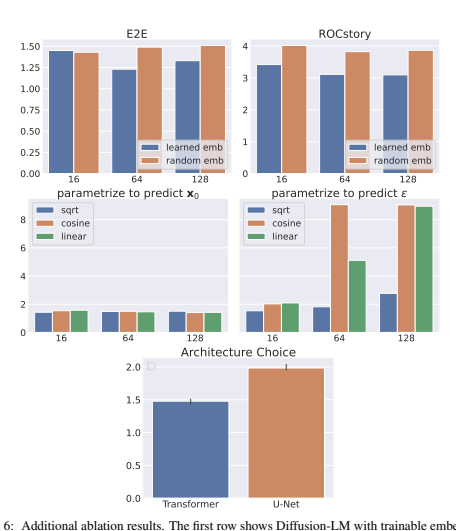



---> Split Source: ./static/LatentDiffusionForLanguageGeneration , MetaData:
 {'chunk_end': 92, 'chunk_start': 87, 'source': './static/LatentDiffusionForLanguageGeneration/LatentDiffusionForLanguageGeneration.md'} , Page Content:
 Table 8: Machine translation results on WMT14-En-De. Baseline results are from
[13, 73].

Method Sampling SacreBLEU
En→De De→En CDCD [13] Random 19.3 24.9

![8_image_0.png](8_image_0.png) LD4LG (MT5-base) Random 21.4 26.2 Diffusion-LM [36] MBR-5 15.3 17.3 CDCD [13] MBR-10 19.7 25.4 DINOISER [73] MBR-5 24.3 28.8 LD4LG (MT5-base) MBR-5 22.4 27.0 We report our machine translation results in Table 8. We observe that LD4LG outperforms the Diffusion-LM and CDCD baselines although it lags behind the DINOISER
baseline. This demonstrates that our method can effectively take advantage of strong pre-trained multilingual language models for effective multilingual generation.

## 6 Future Work

Our experiments demonstrate that latent language diffusion models can genera

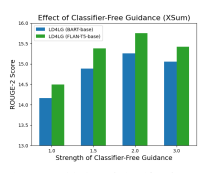

In [11]:
import os, re
from IPython.display import Image, display

def extract_image_filename(text: str) -> str:
    return re.findall(r'!\[.*?\]\((.*?)\)', text)
    
def display_annotated_results(docs):
    for i, d in enumerate(docs):
        directory_path = os.path.dirname(d.metadata['source'])
        img_file_names = extract_image_filename(d.page_content)
        print("\n\n---> Split Source:", directory_path, ", MetaData:\n", d.metadata, ", Page Content:\n", d.page_content)
        for img_file_name in img_file_names:
            img_file_name = img_file_name.lower()
            print("Image file:",directory_path+"/"+img_file_name)
            display( Image(filename=directory_path+"/"+img_file_name) )

question = "Are there discussions about diffusion transformers and how it works ?"

result_docs = vectordb.max_marginal_relevance_search(question, k=8)
display_annotated_results(result_docs)


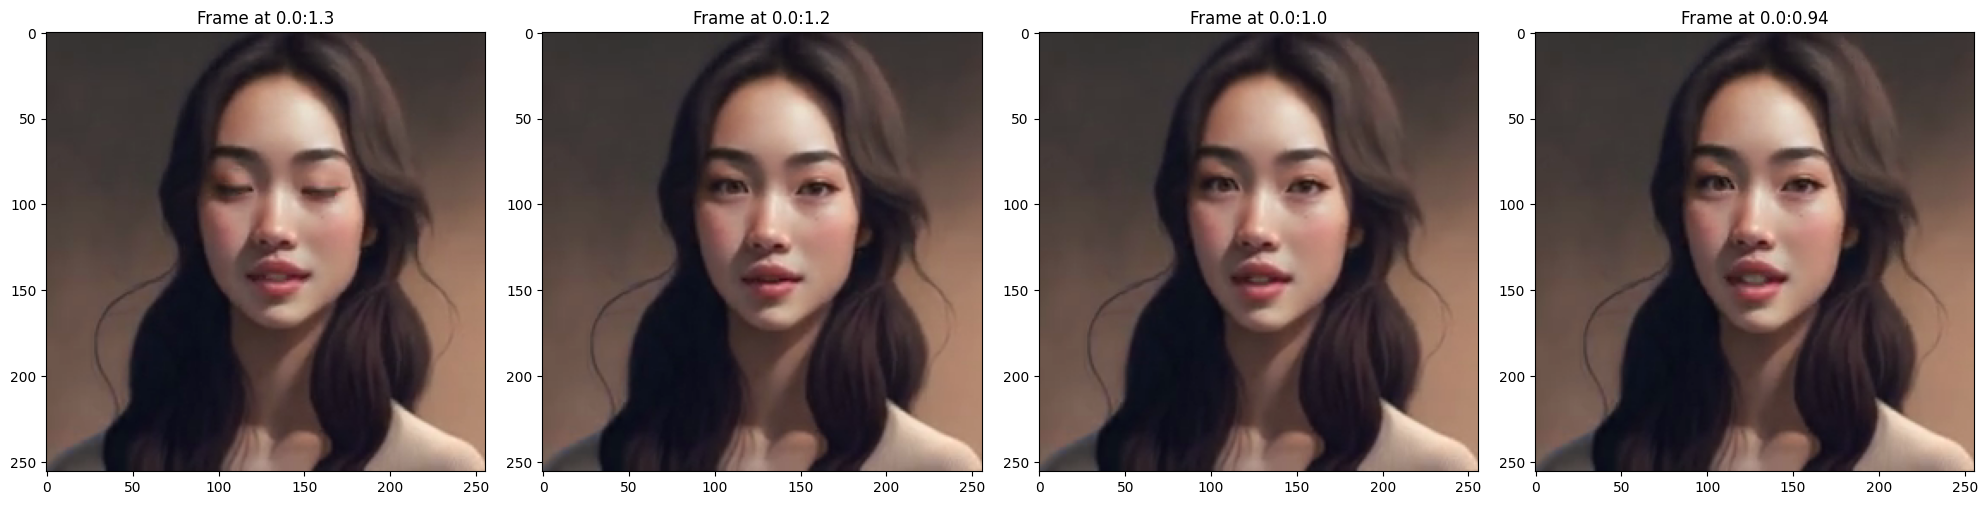

In [12]:
# Extract frames to be used to animate talking AI companion:
#    generated.mp4 created using https://github.com/yoyo-nb/Thin-Plate-Spline-Motion-Model
#    image of girl created via Dall-E 2

from moviepy.editor import VideoFileClip
from PIL import Image
import matplotlib.pyplot as plt

# Load the video
video_path = "generated.mp4"           # generated from ThinPlateSpline project
clip = VideoFileClip(video_path)

frame_times = [1.30, 1.20, 1.00, 0.94] # manually visual inspection of video frames
#frame_times = [3.00, 3.25, 3.37, 3.35] # alternative frames
frame_names = ["frame_blink.jpg","frame_rest.jpg","frame_soft.jpg","frame_loud.jpg"]

fig, axes = plt.subplots(1, 4, figsize=(20, 5))  # 1 row, 4 columns

# Time in seconds to extract the frame
for idx, frame_time in enumerate(frame_times):
    frame = clip.get_frame(frame_time)

    # Plot each frame in its respective subplot
    axes[idx].imshow(frame)
    axes[idx].set_title(f"Frame at {frame_time // 60:02}:{frame_time % 60:02}")
    
    image = Image.fromarray(frame)
    output_path = frame_names[ idx ]

    new_size = (200, 240)  # Width, Height
    resized_image = image.resize(new_size)
    resized_image.save(output_path)

# Adjust layout for better appearance
plt.tight_layout()
plt.show()


In [ ]:
#!python systemOneAgent.py
#

import os
import requests
import numpy as np

import random
import time
from datetime import datetime
import json

from flask import Flask, request, jsonify, render_template, send_file
import pymongo


glob = {}

glob["prompt"]={}
glob["message_counter"] = {}
glob["current_app_state"] = {}
glob["conversation_object"] = {}

glob["image_vector_store_request"]={}
glob["callback_info"]={}
glob["events"]={}

    
from moviepy.editor import * 
#ImageSequenceClip, AudioFileClip, VideoFileClip
from gtts import gTTS
def generate_voice_and_video( user, text, stay_silent_and_blink=False ):
    #print("Generating Voice: ", text)

    tts = gTTS(text=text, lang='en', tld="ca")
    #tts = gTTS(text=text, lang='en', tld="co.uk")

    # Save the .wav file
    tts.save("static/audio.wav")

    # List of image files
    image_files = ["frame_rest.jpg", "frame_soft.jpg", "frame_loud.jpg", "frame_blink.jpg"]
    
    # Load the audio file and get its audio samples
    # NOTE: Bug "AudioFileClip arrays to stack must be passed as a "sequence" type such as list or tuple to_soundarray()" 
    #       Fixed by re-installing moviepy from source ( 2.0.0.dev0 ) --- https://github.com/Zulko/moviepy/issues/1338
    audio_clip = AudioFileClip("static/audio.wav")

    if stay_silent_and_blink:
       audio_clip = AudioFileClip("static/silence.mp3")
       #audio_clip = audio_clip.multiply_volume(0.3)
    
    samples = audio_clip.to_soundarray()
    
    # Create an empty list to store the images for each 1-second time interval
    images = []

    #print("Audio Duration:", audio_clip.duration)

    # Determine the image to display for each 1-second time interval based on the audio volume
    freq = 12; idx = 0;
    for i in range(int(max(audio_clip.duration,1))):
        for j in range(freq):
            start = (idx) * audio_clip.fps // freq
            end = ((idx) + 1) * audio_clip.fps // freq
            mean_volume = np.mean(np.abs(samples[start:end, 0]))

            if stay_silent_and_blink:
                if ((j % 10)==0):
                    images.append(image_files[3])
                else:
                    images.append(image_files[0])
                    
            elif mean_volume > 0.1:
                images.append(image_files[2])
            elif mean_volume > 0.05:
                images.append(image_files[1])
            else:
                if i!=0 and ((i % 2)==0) and ((j % 7)==0):
                    images.append(image_files[3])
                else:
                    images.append(image_files[0])
                #images.append(image_files[0])
            idx += 1
            #print(".", end="")

    # Create an ImageSequenceClip from the list of images
    # NOTE: Re-installing moviepy required the change here ...
    image_sequence = ImageSequenceClip(images, fps=freq).resize(height=320, width=240)
    #image_sequence = ImageSequenceClip(images, fps=freq).resize(newsize=(640, 480))

    # Combine the image sequence and audio clips into a video
    # NOTE: Re-installing moviepy required the change here ...
    final_clip = image_sequence.with_audio(audio_clip)
    #final_clip = image_sequence.set_audio(audio_clip)

    #if stay_silent_and_blink:
    #    final_clip = final_clip.audio_fadein(1.0)

    # Write the video to disk
    final_clip.write_videofile("static/" + "video_"+user+str(glob["message_counter"][user])+".mp4", codec='libx264', bitrate="80k") #, threads=2)
            

import pika

queue_manager_host = "localhost"

# Connect to Queue Manager
#connection = pika.BlockingConnection(pika.ConnectionParameters(host=queue_manager_host))

import threading
def receive_events( user ):
    exchange_name = user+"_events"
    queue_name    = user+"_events"
    event_type    = "events"

    if user not in glob["events"]:
        glob["events"][ user ]=[]
    
    connection = pika.BlockingConnection(pika.ConnectionParameters(host=queue_manager_host))
    channel = connection.channel()
    channel.exchange_declare(exchange=exchange_name, exchange_type='direct')
    result = channel.queue_declare(queue=queue_name)
    channel.queue_bind(exchange=exchange_name, queue=queue_name, routing_key=event_type)

    def receiving_thread():
        print("Event Receiving Thread created for: ", user)
        channel.start_consuming()
        
    def callback(ch, method, properties, body):
        print("Event Receiving Thread received data: ", body)
        glob["events"][ user ].append(body)

    channel.basic_consume(queue=queue_name, on_message_callback=callback, auto_ack=True)    
    mq_recieve_thread = threading.Thread(target=receiving_thread)
    mq_recieve_thread.start()
    

start_time = time.time()

from langchain.vectorstores import Chroma
from langchain.embeddings.openai import OpenAIEmbeddings
persist_directory = './researchdb/'

vectordb = Chroma(embedding_function=OpenAIEmbeddings(), persist_directory=persist_directory)

print("ResearchDB Vector Database Loaded:")

end_time = time.time()

print("Vector Store Load Elapsed time: ", end_time - start_time)
        

import re

# example: "please find in the [image] vector store... for dicussions about transformers"
# returns: (True, 'dicussions about transformers')
def match_image_vector_store_request(input_string):
    pattern = r"\b((can|could)\s*you|please)\s*(look|lookup|find|see|check|search)\b(?:\s+\w+)*\s+image\s+vector\s+store\s*(.+)"; match_position=4;
    return_string=""; matched=False;
    match = re.search(pattern, input_string, re.IGNORECASE)
    if match is not None: 
        return_string = match.group(match_position)
        matched = True
    return matched, return_string

def remove_starting_word(sentence, word_to_remove):
    words = sentence.strip().split()    
    if words and words[0].lower() == word_to_remove.lower():
        words.pop(0)    
    result = ' '.join(words)
    return result



app = Flask(__name__)

@app.route("/")
def index():
    user = "demo"
    
    glob["message_counter"][ user ]=0
    glob["current_app_state"][ user ]="initializing"
    glob["conversation_object"][ user ]=Conversation(system_prompt=system_prompt)
    glob["image_vector_store_request"][user]=False
    
    # Initialize the user specific callback_info structures
    glob["callback_info"][user]={}
    glob["callback_info"][user]["cached_from_callback"]={"system2_prompt":"", "image_prompt":"", "image_dscrpt":""}
            
    glob["prompt"][ user ]=""

    first_message = ""
    random.seed(time.time())
    first_message = random.choice( ["hey, hows it going", "hi, how are you", "hi, hows it going", "hey, how are you doing", "hey, hows it going", "hi, how are you", "hi, hows it going", "hello, how are you doing"] )

    print("The Initial Prompt is: ", system_prompt)    
    print("First Greeting: ", first_message)
    #receive_events(user)

    speech2text_app_id = os.environ.get("SYMBL_AI_APP_ID")
    speech2text_app_secret = os.environ.get("SYMBL_AI_APP_SECRET")

    return render_template("index.html", user=user, message=first_message, speech2text_app_id=speech2text_app_id, speech2text_app_secret=speech2text_app_secret)
    
@app.route("/initialize", methods=["POST"])
def initialize():
    user = request.get_json()["user"]
    text = request.get_json()["text"]
    image_prompt = response = ""
    
    print("Received: ", text, " from: ", user)
        
    if glob["current_app_state"][ user ]=="initializing":
        glob["current_app_state"][ user ]="running"

        # no call to chatGPT here but we will generate voice and wait for next chat
        glob["prompt"][ user ] += "Assistant: " + text + "\n"
        glob["conversation_object"][ user ].assistant( text )

        # generate voice after we get the assistant's next line
        generate_voice_and_video( user, text )

    elif glob["current_app_state"][ user ]=="running":
        assert(False)

    video_file = "video_"+user+str(glob["message_counter"][user])+".mp4"
    glob["message_counter"][user]+=1

    result = jsonify({"video_file": video_file, "image_prompt": image_prompt, "response":response})
    return result
    
@app.route("/chat_think", methods=["POST"])
def chat_think():
    
    user = request.get_json()["user"]
    text = request.get_json()["text"]
    image_data = request.get_json()["image"]

    image_prompt = response = ""
    
    print("Received: ", text, " from: ", user)

    # Process any image that is sent with the chat
    if image_data != "":
        image_data = image_data.replace('data:image/png;base64,', '')
        
        # Save the image locally
        current_dir = './'
        image_file = 'static/image.'+user+'.'+datetime.now().strftime("%Y-%m-%d_%H:%M:%S")+'.png'
        with open(current_dir + image_file, 'wb') as f:
            f.write(base64.b64decode(image_data))

        text = text+". Please describe this image '"+current_dir+image_file+"'"
        response = "pause and think"
        
    # Add the user response to the conversation
    glob["prompt"][ user ] += "User: " + text + "\n"
    glob["conversation_object"][ user ].user( text )

    # (A) Send Dialog to Observers ...
    
    dialog = glob["prompt"][ user ] 
    message_content = {}
    message_content["user"]=user
    message_content["dialog"]=dialog
    message_content["message_counter"]=glob["message_counter"][user]

    exchange_name = "dialog_history"

    connection = pika.BlockingConnection(pika.ConnectionParameters(host=queue_manager_host))
    channel = connection.channel()
    channel.exchange_declare(exchange=exchange_name, exchange_type='fanout')
    channel.basic_publish(exchange=exchange_name, routing_key=user, body=json.dumps(message_content))
    
    print(f"[x] Broadcast DIALOG: {dialog}")
    connection.close()


    glob["image_vector_store_request"][user] = match_image_vector_store_request( text )[0]

    # Process fastpath queries
    stay_silent_and_blink = False
    if response=="pause and think":
        response = random.choice(["ok, let me think", "ok, let me see", "let me think, give me a sec", "give me a sec, let me think"])

    elif glob["image_vector_store_request"][user]:
        stay_silent_and_blink = True
        response = "thinking"
        
    else:
        stay_silent_and_blink = True
        response = "thinking"
    
    start_time = time.time()
    
    # generate voice after we get the assistant's next line
    generate_voice_and_video( user, response, stay_silent_and_blink=stay_silent_and_blink )

    end_time = time.time()
    print("* generate_voice_and_video Elapsed time:", end_time - start_time)    

    video_file = "video_"+user+str(glob["message_counter"][user])+".mp4"
    glob["message_counter"][user]+=1

    result = jsonify({"video_file": video_file, "image_prompt": image_prompt, "response":response})
    return result


def resolve_observer_replies(ch, method, properties, body):
    body = json.loads(body)
    user = body['user']
    reply = str(body['reply'])
    message_counter = body["message_counter"] 
        
    if method.routing_key=="system2":
        glob["callback_info"][user]["cached_from_callback"]["system2_prompt"]=reply
        glob["callback_info"][user]["cached_from_callback"]["image_prompt"]=str(body['image_prompt'])
        glob["callback_info"][user]["cached_from_callback"]["image_dscrpt"]=str(body['image_dscrpt'])

        # Signal receipt of data
        ch.stop_consuming()

        if glob["message_counter"][user] < message_counter:
            print(" CRITICAL ERROR: Out of order message received! For now we will clear the system2 prompt:")
            glob["callback_info"][user]["cached_from_callback"]["system2_prompt"]=""
            glob["callback_info"][user]["cached_from_callback"]["image_prompt"]=""
            glob["callback_info"][user]["cached_from_callback"]["image_dscrpt"]=""


@app.route("/think_reply", methods=["POST"])
def think_reply():
    
    user = request.get_json()["user"]
    text = request.get_json()["text"]
    
    image_prompt = response = ""
    
    # (B) Wait for reply ...
    exchange_name = user
    queue_name = user
    
    connection = pika.BlockingConnection(pika.ConnectionParameters(host=queue_manager_host))
    channel = connection.channel()
    channel.exchange_declare(exchange=exchange_name, exchange_type='direct')
    result = channel.queue_declare(queue=queue_name)

    #start_time = time.time()
    
    channel.queue_bind(exchange=exchange_name, queue=queue_name, routing_key="system2")
    
    print(" [*] Waiting for observers reply. To exit press CTRL+C \n")
    
    channel.basic_consume(queue=queue_name, on_message_callback=resolve_observer_replies, auto_ack=True)
    channel.start_consuming()

    #end_time = time.time()
    #print("* waiting for observers Elapsed time:", end_time - start_time)
    
    connection.close()

    # (C) Process callbacks results ...

    # Retrieve instruction prompts from observers
    system2_prompt  = glob["callback_info"][user]["cached_from_callback"]["system2_prompt"]
    st_image_prompt = glob["callback_info"][user]["cached_from_callback"]["image_prompt"]
    st_image_dscrpt = glob["callback_info"][user]["cached_from_callback"]["image_dscrpt"]
    glob["callback_info"][user]["cached_from_callback"]["system2_prompt"]=""
    glob["callback_info"][user]["cached_from_callback"]["image_prompt"]=""
    glob["callback_info"][user]["cached_from_callback"]["image_dscrpt"]=""

    if st_image_prompt != "":
        image_prompt = st_image_prompt
    if st_image_dscrpt != "":
        system2_prompt += " We returned an image with this description: "+st_image_dscrpt+"."

    # Update the system/context prompts
    if system2_prompt != "":
        glob["conversation_object"][ user ].system( system2_prompt )
        #glob["prompt"][ user ] += "\nContext: " + system2_prompt + "\n"
        glob["prompt"][ user ] += "Assistant: "
    else:
        glob["prompt"][ user ] += "Assistant: " 
        

    if glob["image_vector_store_request"][user]:
        glob["image_vector_store_request"][user]=False

        image_request = match_image_vector_store_request( text )[1]
        image_request = remove_starting_word(image_request, "for")
        query_prefix = "Are there "
        image_request = query_prefix + image_request

        print("---VectorDB search request: "+image_request)
     
        result_docs = vectordb.max_marginal_relevance_search(image_request, k=8)
        for i, d in enumerate(result_docs):
            directory_path = os.path.dirname(d.metadata['source'])
            img_file_names = re.findall(r'!\[.*?\]\((.*?)\)', d.page_content)
            for img_file_name in img_file_names:
                img_file_name = img_file_name.lower()
                image_prompt = directory_path+"/"+img_file_name
                image_prompt = image_prompt.replace("marker_output","static")
                break
            break

        # NOTE: We didn't use the system prompt here to avoid another call to the LLM to possibly 'refine'
        #       the response. We may want to revisit this in the future
        response = analyze_image(image_prompt)

        glob["conversation_object"][ user ].assistant( response )
        glob["prompt"][ user ] += response + "\n"
        
    else:
        
        # We call chatGPT for the next response. 
        start_time = time.time()
    
        #print("Preparing reply: ", glob["prompt"][ user ])
        #prompt = glob["prompt"][ user ]
        #response = call_open_ai(prompt)

        # Continue the conversation ...
        response = glob["conversation_object"][ user ].chat()
        
        glob["prompt"][ user ] += response + "\n"
        
        end_time = time.time()
        print("* call_open_ai Elapsed time:", end_time - start_time)
    

    # Generate voice after we get the assistant's next line
    start_time = time.time()
    
    generate_voice_and_video( user, response )

    end_time = time.time()
    print("* generate_voice_and_video Elapsed time:", end_time - start_time)


    video_file = "video_"+user+str(glob["message_counter"][user])+".mp4"
    glob["message_counter"][user]+=1

    result = jsonify({"video_file": video_file, "image_prompt": image_prompt, "response":response})

    return result



from http.server import BaseHTTPRequestHandler
class RequestHandler(BaseHTTPRequestHandler):
  def setup(self):
    BaseHTTPRequestHandler.setup(self)
    self.request.settimeout(120)

if __name__ == "__main__":
    app.run(host='0.0.0.0', port=7778, threaded=True)


In [ ]:
glob["conversation_object"][ 'demo' ].messages